In [1]:
# This file includes JuliaMBD from source codes directly.
# If JuliaMBD is installed from GitHub, please use the following codes:
#
# using Pkg
# Pkg.add(url="https://github.com/JuliaMBD/JuliaMBD.jl.git")
# using Plots
# using DifferentialEquations
# using JuliaMBD
# using JuliaMBD.Diagram

include("../src/JuliaMBD.jl")
using DifferentialEquations
using Plots
using .JuliaMBD
using .JuliaMBD.Diagram

In [2]:
## MSD

@model MSD begin
    @parameter begin
        M
        D
        k
        g = 9.8
    end
    @xmlmodel("MSD.drawio", "msd")
end

MSD (generic function with 1 method)

In [3]:
## test

@model Test begin
    @parameter begin
        M
        D
        k
        f
        p_cycle
        p_width
    end
    @xmlmodel("MSD.drawio", "testmodel")
    @scope begin
        msd.in => F
        msd.out => x
    end
end

┌ Warning: The port Dict{Any, Any}("label" => "<p style=\"line-height: 100%;\"><br></p>", "name" => "out", "id" => "S0-hgQaqpSkl1TX0nI0X-3", "parent" => "S0-hgQaqpSkl1TX0nI0X-1", "type" => "outport") has not been used.
└ @ Main.JuliaMBD.Diagram /workspaces/JuliaMBD.jl/src/diagrams/_xml2model.jl:76


Test (generic function with 1 method)

  4.754815 seconds (19.66 M allocations: 1.061 GiB, 3.37% gc time, 99.64% compilation time: 9% of which was recompilation)


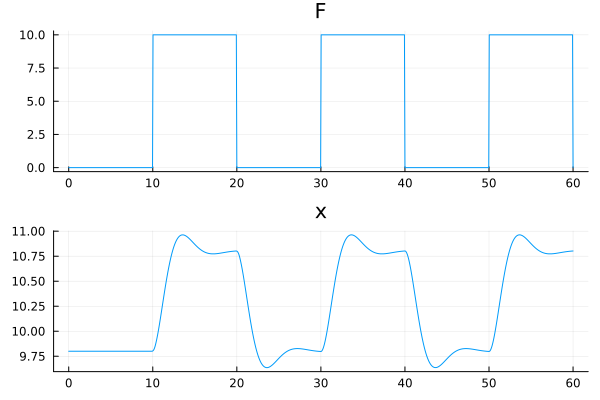

In [4]:
@time begin
    m = @compile Test(M=10, D=10, k=10, f=10, p_cycle=20, p_width=50)
    result = simulate(m, tspan=(0.0, 60.0))
    plot(result)
end

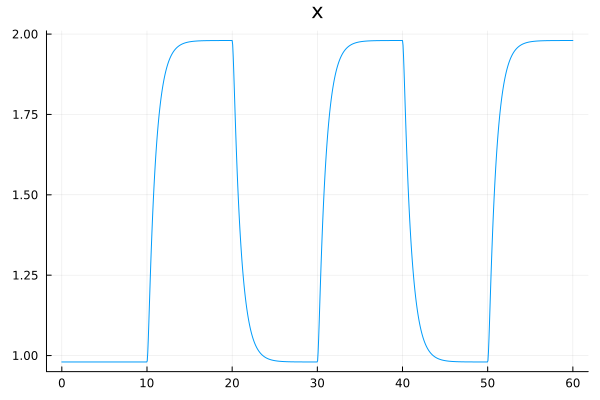

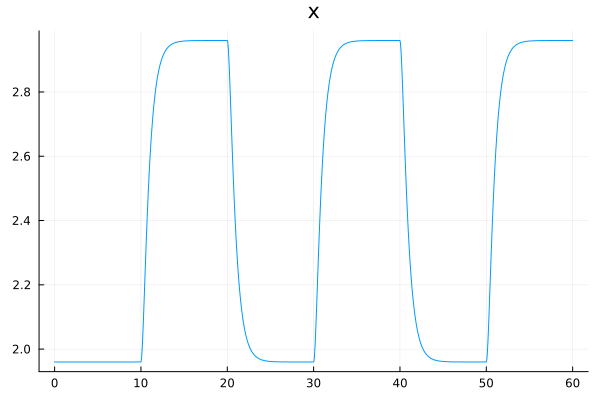

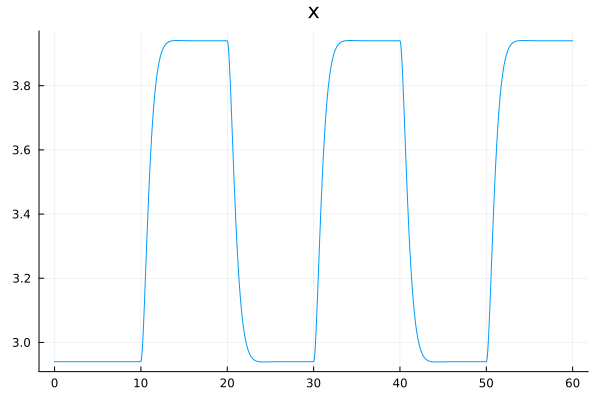

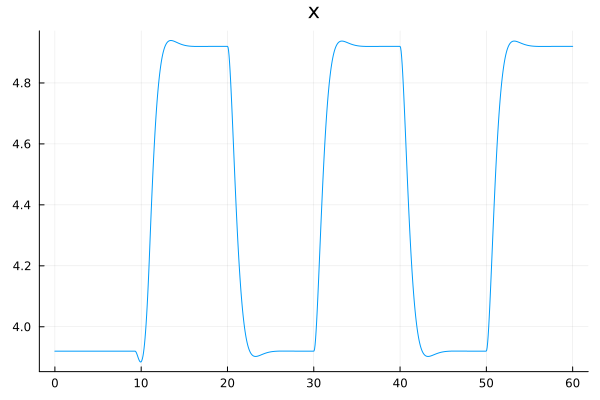

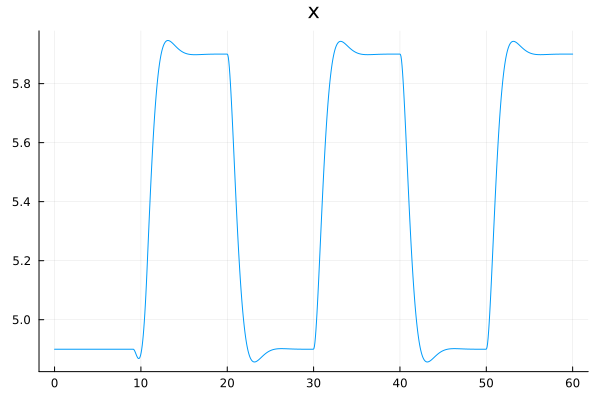

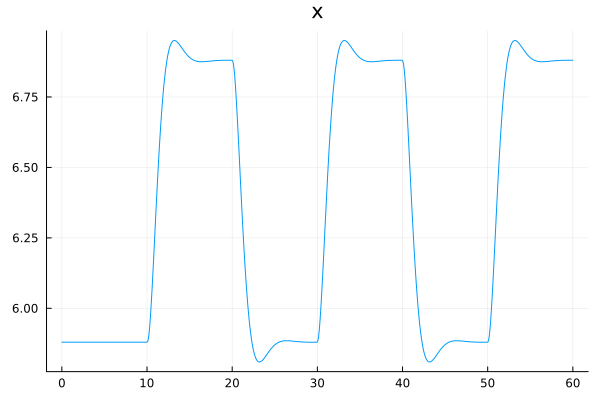

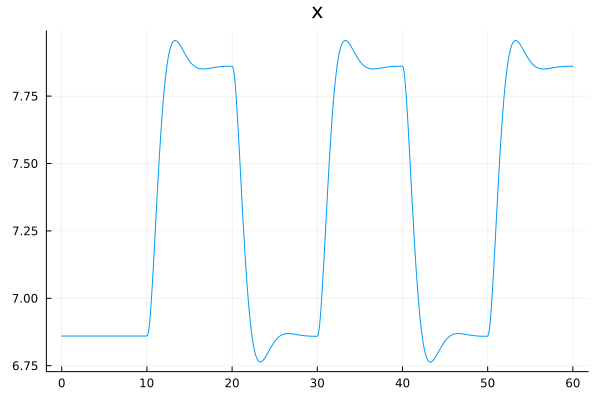

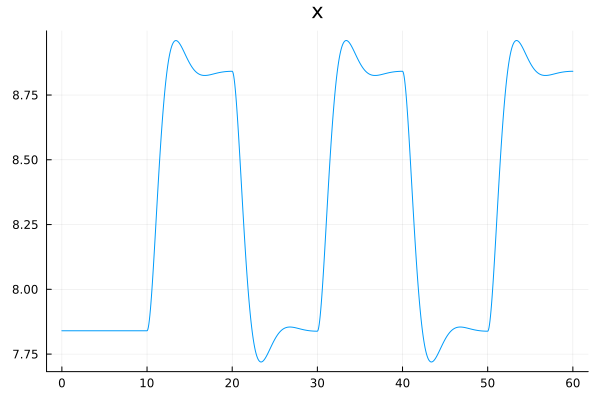

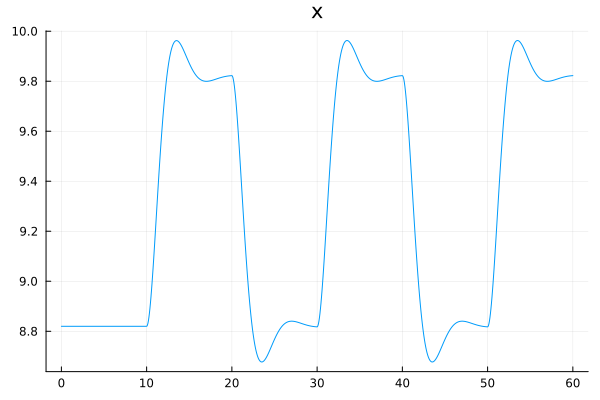

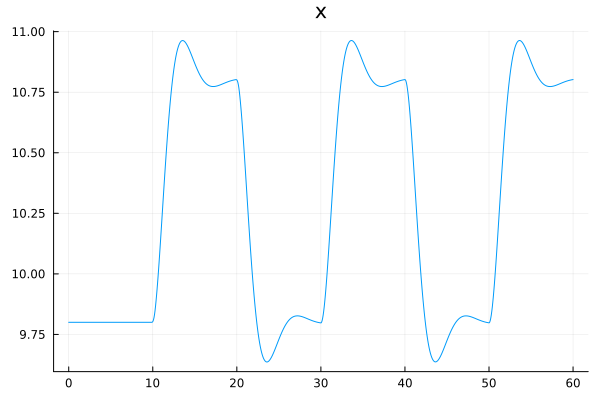

  0.636669 seconds (1.06 M allocations: 64.948 MiB, 17.65% gc time, 52.01% compilation time)


In [8]:
@time begin
    m = @compile Test(D=10, k=10, f=10, p_cycle=20, p_width=50) # M is a variable parameter
    for M = 1:10
        result = simulate(m, tspan=(0.0, 60.0), parameters=(M=M,))
        display(plot(result, vars=[:x]))
    end
end